In [1]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.linalg import block_diag

module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = os.path.abspath(os.path.join('../../data'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from dynamics import Dynamics
from utils import get_form_initial_conditions
from centralized_newton import CentralizedNewton

In [2]:
# Position estimation error
def position_estimation_error(X_est, X_true):
    return np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).flatten(), np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).flatten(), np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).flatten(), np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).flatten()

In [3]:
# Simulation parameters
dt = 60.0  # Time step [s]
K = 395  # Duration [min]
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6 
n_p = 3  
n = N * n_x
o = 3 + 3 * 3
H = 2 # Window size [min]
invalid_rmse = 1e20 # [m]
grad_norm_order_mag = True
grad_norm_tol = 1e-6
max_iterations = 20
dyn = Dynamics()

In [4]:
# Observation noise
r_chief_pos = 1e1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e-1  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(9)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P_0 = np.diag(np.concatenate([p_pos_initial * np.ones(3), p_vel_initial * np.ones(3)])) ** 2
P_0 = block_diag(P_0, P_0, P_0, P_0)

In [5]:
def plots(k, algorithm_class):
    iterations = np.arange(0, algorithm_class.iterations + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1
    axs[0].semilogy(iterations, 1 / H * np.array(algorithm_class.cost_values), '.-')
    axs[0].set_xlabel(r'$n$')
    axs[0].set_ylabel(r'$\frac{1}{H}J(x_n)$')
    axs[0].set_title('Normalized Cost Function') 
    axs[0].grid()

    # Plot 2
    axs[1].semilogy(iterations, 1 / H * np.array(algorithm_class.gradient_norm_values), '.-')
    axs[1].set_xlabel(r'$n$')
    axs[1].set_ylabel(r'$\frac{1}{H}||\nabla J(x_n)||_2$')
    axs[1].set_title('Normalized Gradient Norm')
    axs[1].grid()
    
    fig.suptitle(f'Solving MHE problem J(k) with k = {k}', fontsize=14)

    plt.tight_layout()
    plt.show()

In [6]:
# Seed for reproducibility
np.random.seed(42)

# Initial conditions for the state vector and true state vectors
X_initial = get_form_initial_conditions(formation)
with open(f"../../data/tudatpy_form{formation}_ts_{int(dt)}.pkl", "rb") as file:
    X_true = pickle.load(file)[:, :, :K]

# Initial position estimation error
X_est = np.zeros_like(X_true)
X_est[:, :, 0] = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))
for k in range(K - 1):
    X_est[:, :, k + 1] = dyn.f(dt, X_est[:, :, k])
position_estimation_error_1_initial, position_estimation_error_2_initial, position_estimation_error_3_initial, position_estimation_error_4_initial = position_estimation_error(X_est, X_true)

# Algorithm class to use
centralized_newton = CentralizedNewton(H, K, o, R, grad_norm_order_mag, grad_norm_tol, max_iterations)

# Observations
Y = np.zeros((o, 1, K))
for k in range(K):
    Y[:, :, k] = centralized_newton.h(X_true[:, :, k]) + np.random.multivariate_normal(np.zeros(o), R).reshape((o, 1))

Windows:   0%|          | 0/394 [00:00<?, ?it/s]

[Centralized Newton] Before applying the algorithm
Cost function: 22457811.853896968
Gradient norm: 5119707.284908178
Global estimation error: 340.1927477029396
Hessian matrix minimum eigenvalue: 0.002499255962841535
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 3.011456980755562e-08
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.002499255962841535
Initial conditions estimation errors: 156.54981060767048 m, 116.92997375849691 m, 132.60145384314228 m, 244.88261581428247 m
Position estimation errors: 157.6985251003501 m, 116.73925644612086 m, 133.21214115229438 m, 243.90800773348906 m

[Centralized Newton] Iteration 1
Cost function: 0.009215248519002663 (-100.00%)
Gradient norm: 0.6252930864796621 (-100.00%)
Global estimation error: 23.59567666161554 (-93.06%)
Hessian matrix minimum eigenvalue: 0.0024992547223479126
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 4.766795250589933e-15
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.0024992547223479126
Initial conditions estimation

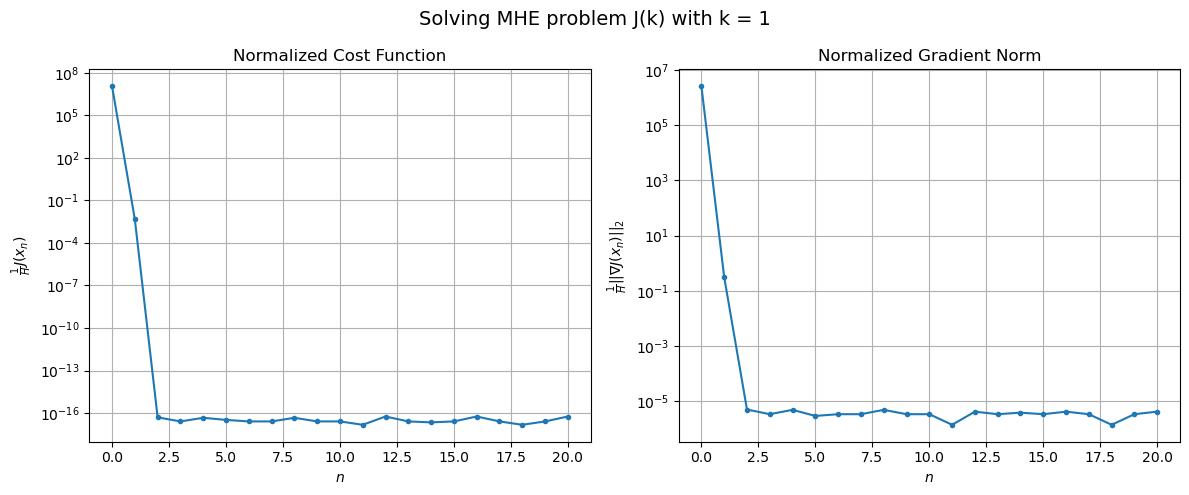

Windows:   0%|          | 1/394 [00:34<3:44:25, 34.26s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 21.28606009312297
Gradient norm: 3853.1270422882
Global estimation error: 47.542349207145364
Hessian matrix minimum eigenvalue: 0.0024992545980828443
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 2.0127520299319827e-11
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.0024992545980828443
Initial conditions estimation errors: 23.76554054981409 m, 23.7384916944548 m, 23.696830310258477 m, 23.872225309651967 m
Position estimation errors: 43.811773478339425 m, 43.852260335732105 m, 43.59937050551694 m, 44.14545977222149 m

[Centralized Newton] Iteration 1
Cost function: 5.951485590520675e-15 (-100.00%)
Gradient norm: 3.238956628607185e-05 (-100.00%)
Global estimation error: 47.54004026387471 (-0.00%)
Hessian matrix minimum eigenvalue: 0.0024992545223000277
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 2.8499200800901495e-19
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.0024992545223000277
Initial conditions estimatio

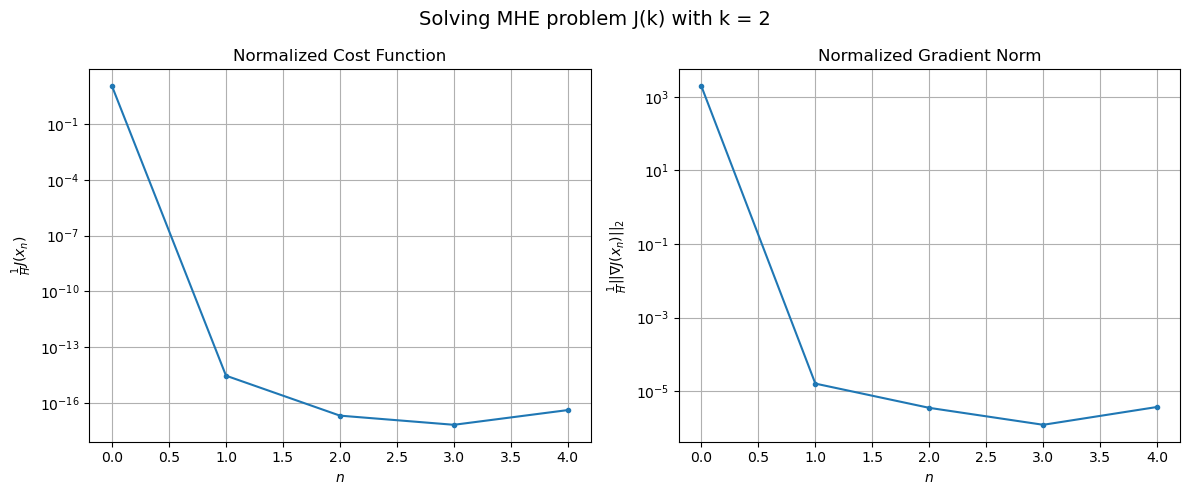

Windows:   1%|          | 2/394 [00:45<2:13:37, 20.45s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 14.369367208822933
Gradient norm: 3315.4279816162375
Global estimation error: 36.49068251468038
Hessian matrix minimum eigenvalue: 0.002499254627589339
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 2.330299197307072e-11
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.002499254627589339
Initial conditions estimation errors: 18.252162988437924 m, 18.23197130535943 m, 18.32129820784816 m, 18.167240220780453 m
Position estimation errors: 25.17194090281304 m, 25.172987606671008 m, 25.371610768169862 m, 25.053667970498736 m

[Centralized Newton] Iteration 1
Cost function: 1.5863079379524767e-15 (-100.00%)
Gradient norm: 3.256789820618989e-05 (-100.00%)
Global estimation error: 36.49417342660052 (0.01%)
Hessian matrix minimum eigenvalue: 0.0024992546812361216
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 2.506729760451284e-19
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.0024992546812361216
Initial conditions estimati

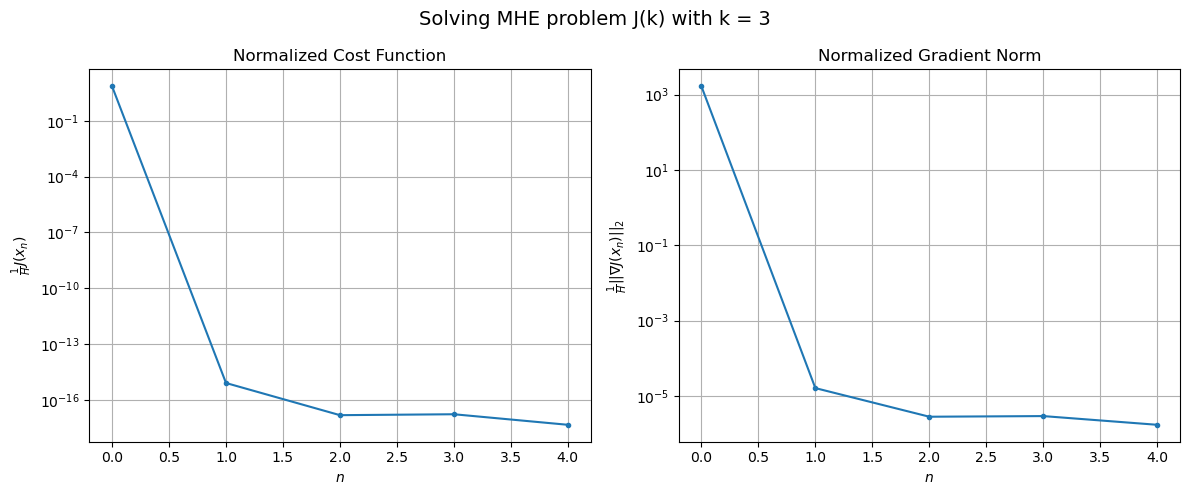

Windows:   1%|          | 3/394 [00:53<1:38:02, 15.04s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 22.35385837995073
Gradient norm: 6997.349493172039
Global estimation error: 24.284226517974503
Hessian matrix minimum eigenvalue: 0.0024992545780495143
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 4.103959196781517e-11
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.0024992545780495143
Initial conditions estimation errors: 12.198583034879578 m, 12.07954639270293 m, 12.111502748705199 m, 12.153726109594007 m
Position estimation errors: 32.75683199076916 m, 32.651974257103994 m, 32.77871340446049 m, 32.73032725436862 m

[Centralized Newton] Iteration 1
Cost function: 3.1840311393695057e-15 (-100.00%)
Gradient norm: 3.7567900982430523e-05 (-100.00%)
Global estimation error: 24.28452199888392 (0.00%)
Hessian matrix minimum eigenvalue: 0.0024992546615089325
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 2.720127475217295e-19
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.0024992546615089325
Initial conditions estimat

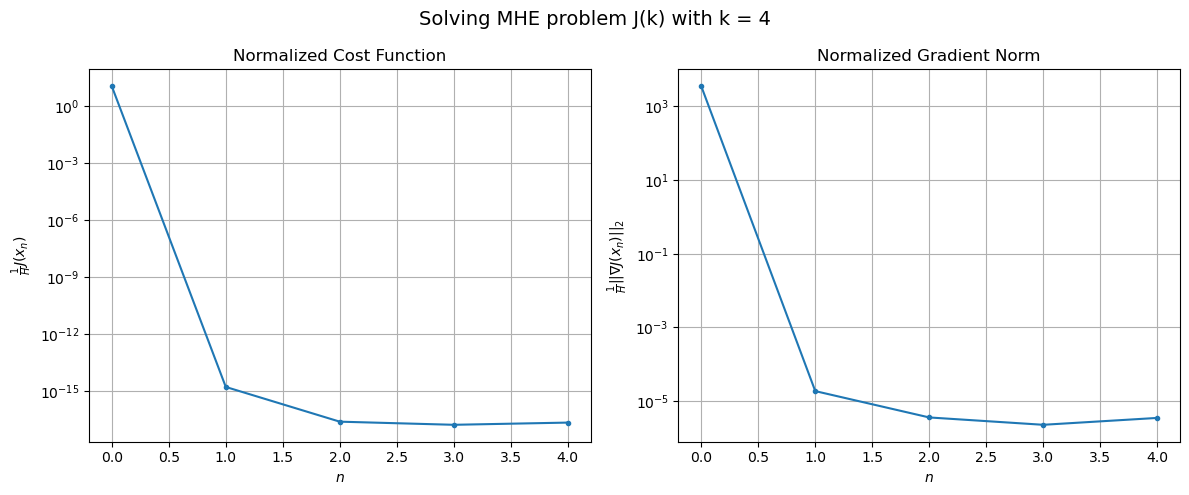

Windows:   1%|          | 4/394 [01:01<1:20:35, 12.40s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 51.224556128038564
Gradient norm: 6058.905819718647
Global estimation error: 61.071267977287114
Hessian matrix minimum eigenvalue: 0.0024992546693147193
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 3.512745571281507e-11
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.0024992546693147193
Initial conditions estimation errors: 30.5163197078754 m, 30.636354393356015 m, 30.545599419928784 m, 30.433707615903216 m
Position estimation errors: 53.54558496085781 m, 53.91489963081963 m, 53.674351746053574 m, 53.303022532381604 m

[Centralized Newton] Iteration 1
Cost function: 3.5689914741164356e-14 (-100.00%)
Gradient norm: 0.00010035728750772278 (-100.00%)
Global estimation error: 61.08210846236769 (0.02%)
Hessian matrix minimum eigenvalue: 0.0024992545870612696
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 8.130798451923427e-19
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.0024992545870612696
Initial conditions estima

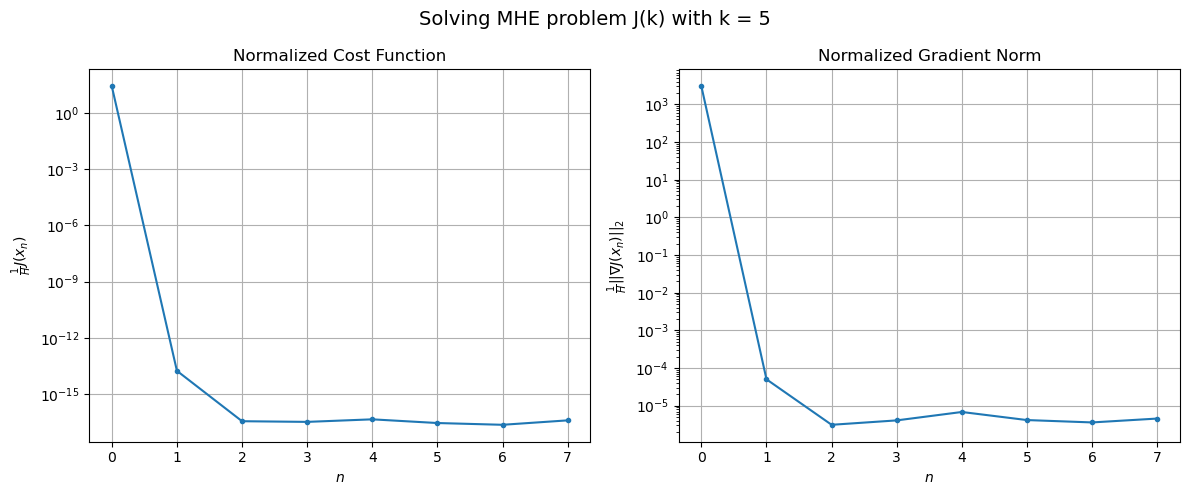

Windows:   1%|▏         | 5/394 [01:18<1:29:20, 13.78s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 41.713925930504416
Gradient norm: 4557.045315577895
Global estimation error: 26.3831882035256
Hessian matrix minimum eigenvalue: 0.0024992546275662253
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 2.5970444734721636e-11
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.0024992546275662253
Initial conditions estimation errors: 13.203723239469285 m, 13.137969381136848 m, 13.239507420019278 m, 13.11252719081572 m
Position estimation errors: 53.292666083122306 m, 53.23633986701462 m, 53.46227723435171 m, 53.006231927165565 m

[Centralized Newton] Iteration 1
Cost function: 2.0553214372222463e-14 (-100.00%)
Gradient norm: 5.736903017063535e-05 (-100.00%)
Global estimation error: 26.352589610238535 (-0.12%)
Hessian matrix minimum eigenvalue: 0.002499254664996183
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 4.739376171841484e-19
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.002499254664996183
Initial conditions estimat

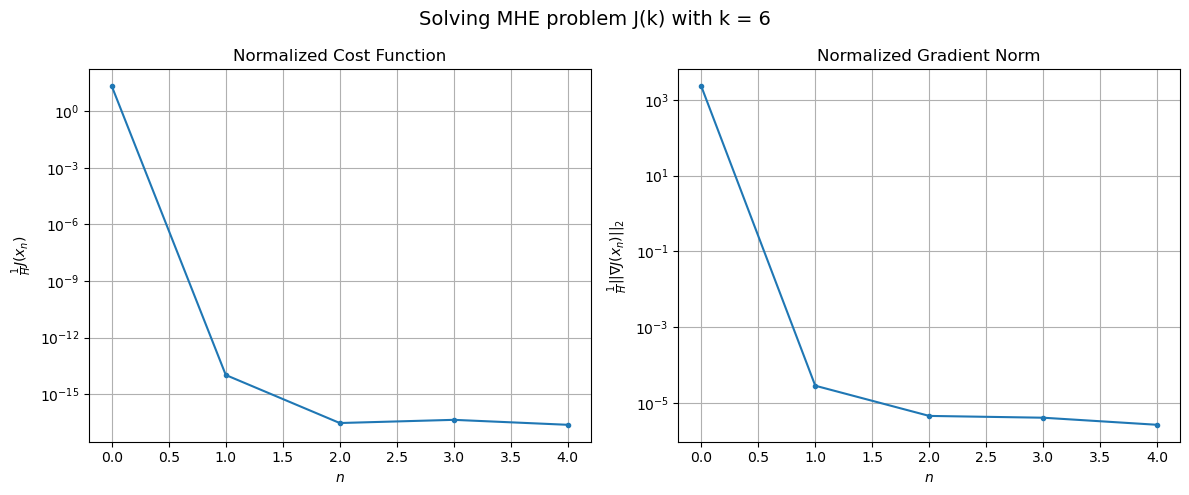

Windows:   2%|▏         | 6/394 [01:26<1:16:31, 11.83s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 24.140492126757096
Gradient norm: 4499.122040265724
Global estimation error: 7.900987294752301
Hessian matrix minimum eigenvalue: 0.0024992544984040197
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 2.6832857922079752e-11
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.0024992544984040197
Initial conditions estimation errors: 3.9479516340601437 m, 4.104840395021497 m, 3.8375070914096545 m, 3.869198488605644 m
Position estimation errors: 19.581431842352544 m, 19.794133714824277 m, 19.472877371899358 m, 19.37284022113074 m

[Centralized Newton] Iteration 1
Cost function: 4.475161171778868e-15 (-100.00%)
Gradient norm: 2.6746430462207825e-05 (-100.00%)
Global estimation error: 7.908192215590209 (0.09%)
Hessian matrix minimum eigenvalue: 0.0024992545198732063
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 1.520404208929988e-19
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.0024992545198732063
Initial conditions estima

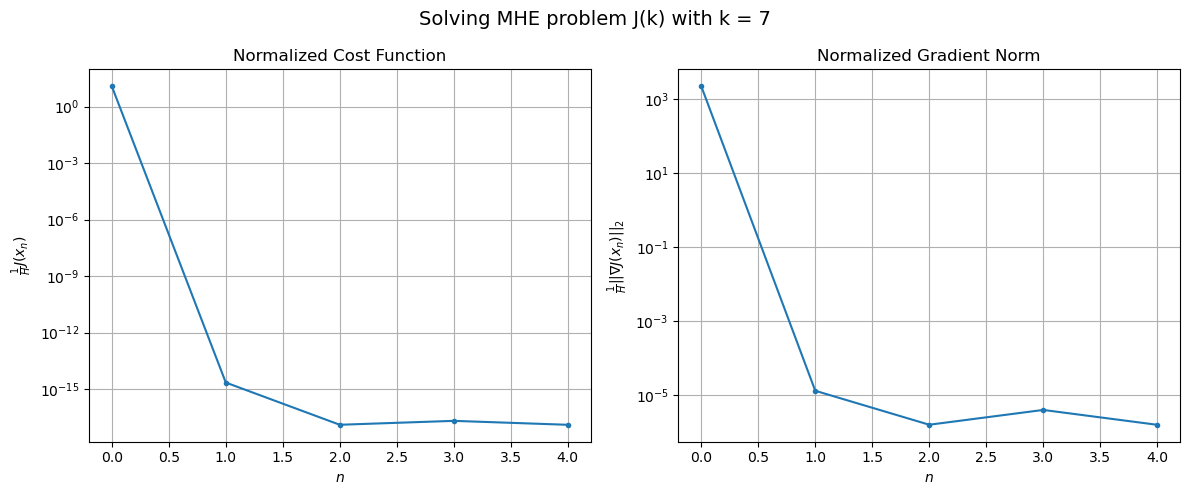

Windows:   2%|▏         | 7/394 [01:33<1:06:45, 10.35s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 28.688968666934475
Gradient norm: 5096.416446648417
Global estimation error: 38.58505606553924
Hessian matrix minimum eigenvalue: 0.0024992547596016756
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 3.095214467631301e-11
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.0024992547596016756
Initial conditions estimation errors: 19.374099655928326 m, 19.280310971728387 m, 19.129585337067883 m, 19.37385489615765 m
Position estimation errors: 39.25865379377691 m, 39.112775648526494 m, 38.712762982562936 m, 39.23462598529394 m

[Centralized Newton] Iteration 1
Cost function: 1.0630763948158097e-14 (-100.00%)
Gradient norm: 7.932952788276788e-05 (-100.00%)
Global estimation error: 38.597057936167204 (0.03%)
Hessian matrix minimum eigenvalue: 0.002499254604374083
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 5.088319287536967e-19
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.002499254604374083
Initial conditions estimati

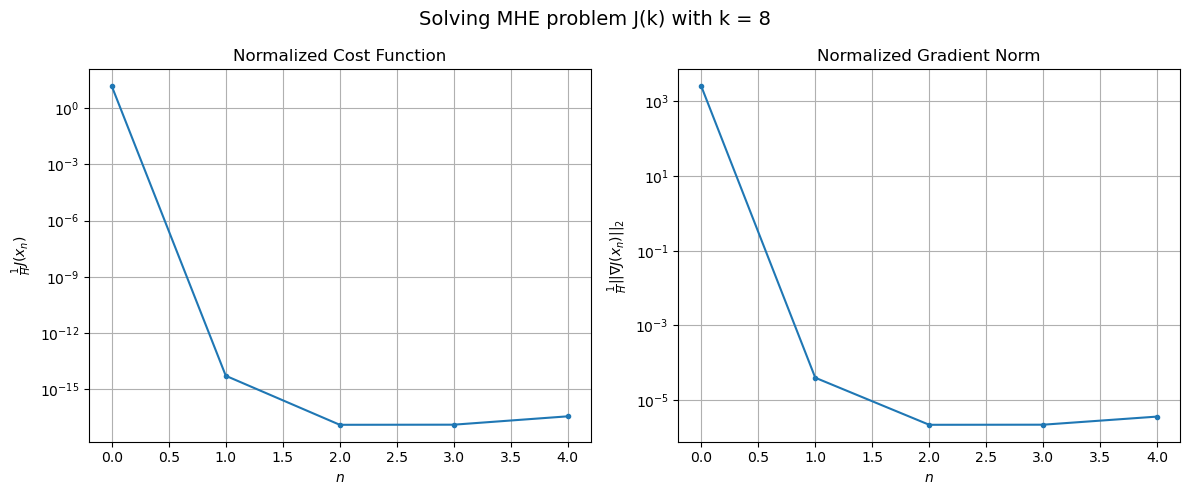

Windows:   2%|▏         | 8/394 [01:45<1:08:47, 10.69s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 42.40532367501863
Gradient norm: 6338.033652214207
Global estimation error: 37.073726792096544
Hessian matrix minimum eigenvalue: 0.00249925444211568
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 4.44512289469299e-11
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.00249925444211568
Initial conditions estimation errors: 18.494726175246573 m, 18.555259640976274 m, 18.573807138066968 m, 18.488117028066426 m
Position estimation errors: 51.5587436313158 m, 51.64981036410163 m, 51.624907896876906 m, 51.58171441703912 m

[Centralized Newton] Iteration 1
Cost function: 3.1484798287668406e-14 (-100.00%)
Gradient norm: 0.0002171789198077058 (-100.00%)
Global estimation error: 37.071819472084506 (-0.01%)
Hessian matrix minimum eigenvalue: 0.0024992546248196216
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 1.8863094702473033e-18
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.0024992546248196216
Initial conditions estimation

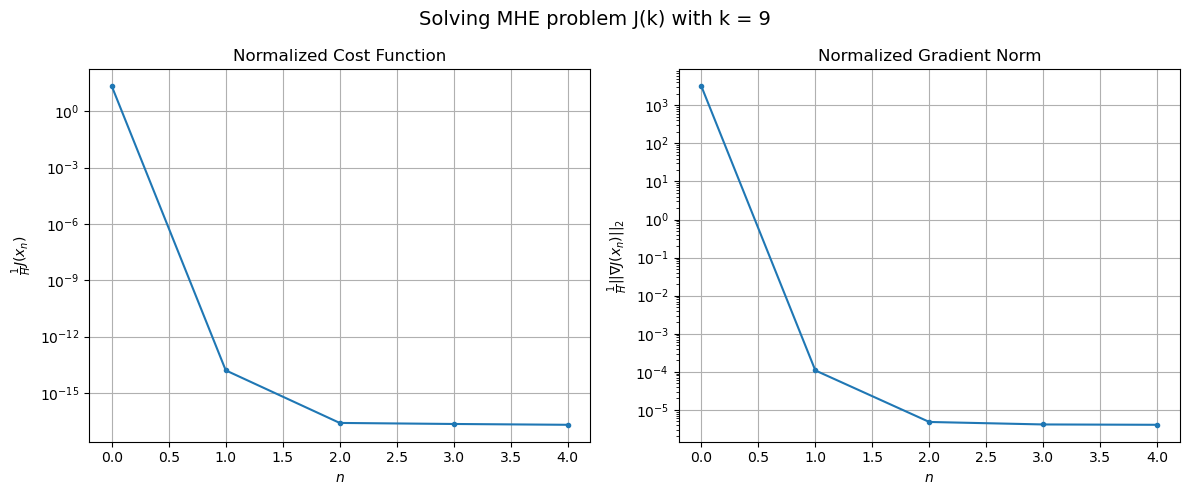

Windows:   2%|▏         | 9/394 [01:55<1:09:10, 10.78s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 45.80613935887262
Gradient norm: 9458.37375823037
Global estimation error: 29.481461665096298
Hessian matrix minimum eigenvalue: 0.0024992547302825764
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 6.550538133719838e-11
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.0024992547302825764
Initial conditions estimation errors: 14.82605778019191 m, 14.670241776134272 m, 14.710558075332576 m, 14.714678043872434 m
Position estimation errors: 47.95297559891413 m, 47.675075735427654 m, 47.7876226316206 m, 47.69366617769251 m

[Centralized Newton] Iteration 1
Cost function: 2.9086057606077696e-14 (-100.00%)
Gradient norm: 0.0001582397079957658 (-100.00%)
Global estimation error: 29.464691066839475 (-0.06%)
Hessian matrix minimum eigenvalue: 0.0024992545532783006
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 1.2363813599689034e-18
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.0024992545532783006
Initial conditions estimat

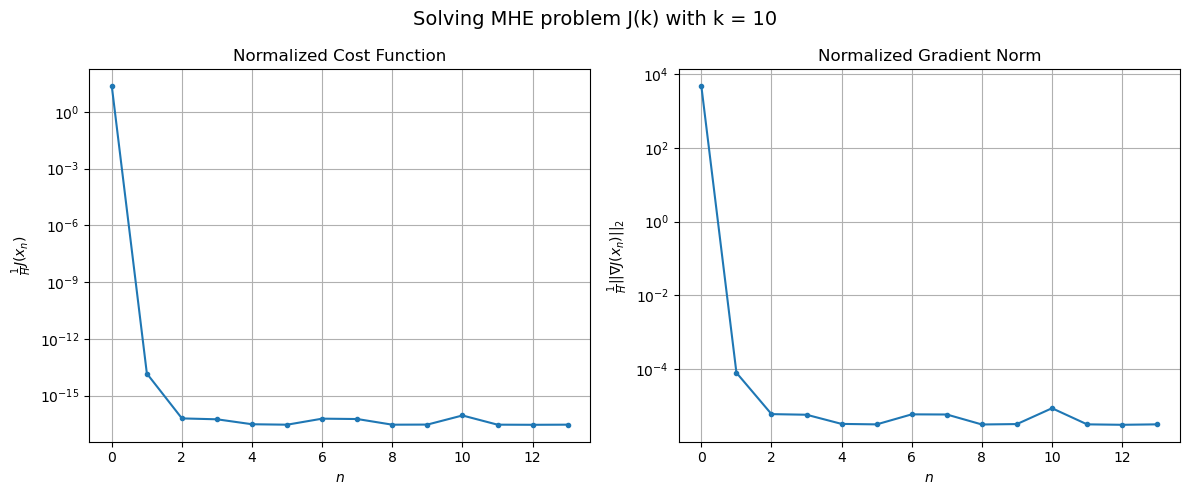

Windows:   3%|▎         | 10/394 [02:16<1:27:18, 13.64s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 31.88379757088111
Gradient norm: 8552.46520952429
Global estimation error: 29.79718331966202
Hessian matrix minimum eigenvalue: 0.00249925454336856
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 6.669262703019251e-11
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.00249925454336856
Initial conditions estimation errors: 14.862143623045908 m, 14.941085248065699 m, 14.842487943847134 m, 14.941351983163576 m
Position estimation errors: 24.691764857526465 m, 24.842055234776087 m, 24.458712684380025 m, 24.862477864828122 m

[Centralized Newton] Iteration 1
Cost function: 9.154384462617368e-15 (-100.00%)
Gradient norm: 3.807782040439864e-05 (-100.00%)
Global estimation error: 29.79887928045038 (0.01%)
Hessian matrix minimum eigenvalue: 0.0024992546743718537
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 3.030006911270792e-19
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.0024992546743718537
Initial conditions estimation 

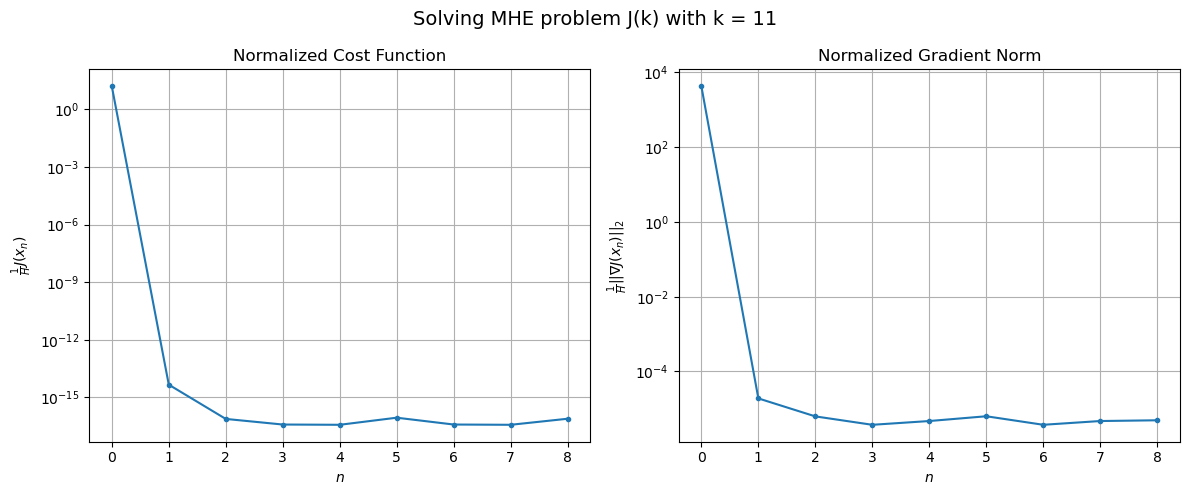

Windows:   3%|▎         | 11/394 [02:29<1:26:32, 13.56s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 28.913232889148066
Gradient norm: 6147.03672973487
Global estimation error: 45.26610660780274
Hessian matrix minimum eigenvalue: 0.0024992545713403117
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 4.859953309758868e-11
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.0024992545713403117
Initial conditions estimation errors: 22.63810103759058 m, 22.590442600356717 m, 22.630832960882444 m, 22.666348074500878 m
Position estimation errors: 36.266035634169846 m, 36.18625907206785 m, 36.46263776084448 m, 36.369740078679555 m

[Centralized Newton] Iteration 1
Cost function: 1.0191784780648334e-14 (-100.00%)
Gradient norm: 0.00011238291981557024 (-100.00%)
Global estimation error: 45.270273366787876 (0.01%)
Hessian matrix minimum eigenvalue: 0.0024992546463082225
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 9.585813656509587e-19
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.0024992546463082225
Initial conditions estima

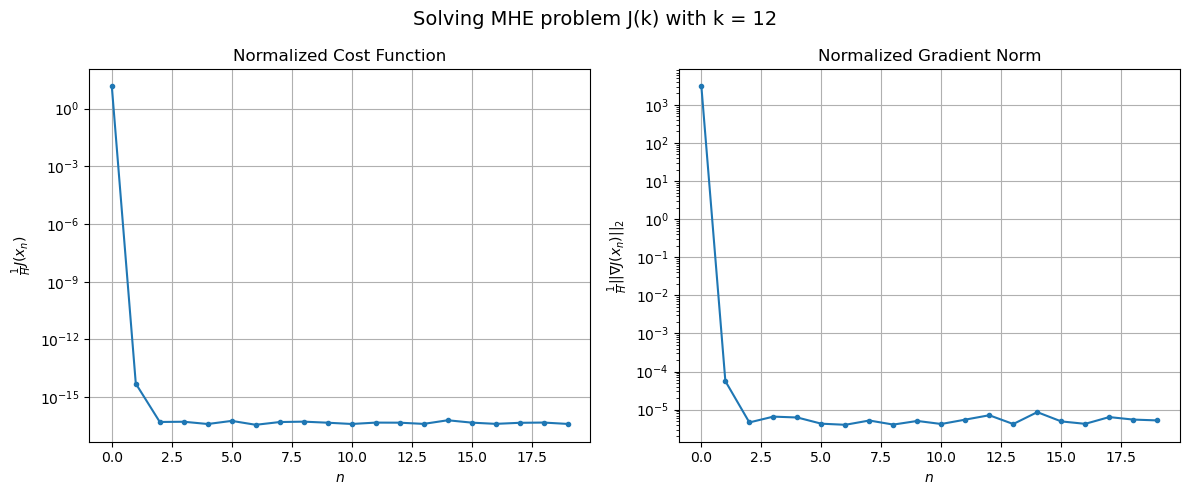

Windows:   3%|▎         | 12/394 [03:01<2:01:50, 19.14s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 25.910665832436774
Gradient norm: 4327.283373698502
Global estimation error: 23.705830205792402
Hessian matrix minimum eigenvalue: 0.002499254601865712
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 3.2781128937723453e-11
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.002499254601865712
Initial conditions estimation errors: 11.914568617472641 m, 11.700389310359027 m, 11.911108843641712 m, 11.855744391373424 m
Position estimation errors: 31.510791863911503 m, 31.33278769055168 m, 31.63757885881611 m, 31.42446604198829 m

[Centralized Newton] Iteration 1
Cost function: 1.1754920015280302e-14 (-100.00%)
Gradient norm: 5.4532797998642743e-05 (-100.00%)
Global estimation error: 23.693465676719953 (-0.05%)
Hessian matrix minimum eigenvalue: 0.002499254656885121
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 3.5622172252197903e-19
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.002499254656885121
Initial conditions estim

[Centralized Newton] Iteration 4
Cost function: 1.1397762322676842e-16 (49.06%)
Gradient norm: 1.3557793219987868e-05 (54.08%)
Global estimation error: 23.693464239434174 (-0.00%)
Hessian matrix minimum eigenvalue: 0.0024992546928829973
Ratios ||A|| / ||C||, ||B|| / ||C||: 0.0, 1.0413954610984201e-19
Spectral radius inv(T) @ R: 0.0
T minimum eigenvalue: 0.0024992546928829973
Initial conditions estimation errors: 11.914568617472641 m, 11.700389310618036 m, 11.911108843641712 m, 11.855744390674772 m
Position estimation errors: 15.076436744250126 m, 14.978881294017683 m, 15.05870029526553 m, 15.160444865143965 m



KeyboardInterrupt: 

In [7]:
first_round_stop_iteration = []
K_minus_H_next_rounds_stop_iteration = []

# Cold-start
x_init = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))

# Apply the algorithm
X_est = np.zeros((n, 1, K))
for k in tqdm(range(H - 1, K), desc="Windows", leave=False):
    centralized_newton.cost_values, centralized_newton.gradient_norm_values = [], []
    x_init, x_est = centralized_newton.solve_MHE_problem_with_metrics(k, dt, Y, x_init, X_true[:, :, k - H + 1],  X_true[:, :, k])
    X_est[:, :, k] = x_est
    
    plots(k, centralized_newton)

    # Warm-start
    x_init = dyn.f(dt, x_init)

# After each Monte Carlo Run compute the RMSE_m for each K - H + 1 timestamps
position_estimation_error_1, position_estimation_error_2, position_estimation_error_3, position_estimation_error_4 = [], [], [], []
for k in range(H - 1, K):
    position_estimation_error_1.append(np.linalg.norm(X_est[:n_p, :, k] - X_true[:n_p, :, k]))
    position_estimation_error_2.append(np.linalg.norm(X_est[n_x:n_x + n_p, :, k] - X_true[n_x:n_x + n_p, :, k]))
    position_estimation_error_3.append(np.linalg.norm(X_est[2*n_x:2*n_x + n_p, :, k] - X_true[2*n_x:2*n_x + n_p, :, k]))
    position_estimation_error_4.append(np.linalg.norm(X_est[3*n_x:3*n_x + n_p, :, k] - X_true[3*n_x:3*n_x + n_p, :, k]))
rmse_1 = np.sqrt(np.mean(np.array(position_estimation_error_1) ** 2))
rmse_2 = np.sqrt(np.mean(np.array(position_estimation_error_2) ** 2))
rmse_3 = np.sqrt(np.mean(np.array(position_estimation_error_3) ** 2))
rmse_4 = np.sqrt(np.mean(np.array(position_estimation_error_4) ** 2))
print(f'This Monte Carlo run RMSE for {K - H + 1} timestamps:')
print(f'RMSE_1 = {np.mean(rmse_1)}\nRMSE_2 = {np.mean(rmse_2)}\nRMSE_3 = {np.mean(rmse_3)}\nRMSE_4 = {np.mean(rmse_4)}')
print(f'CentralizedNewton applied to J(H - 1) converged with {first_round_stop_iteration} iterations.')
print(f'CentralizedNewton applied to J(k) with k = H, ..., K - 1 converged with {np.mean(K_minus_H_next_rounds_stop_iteration)} iterations on average.')

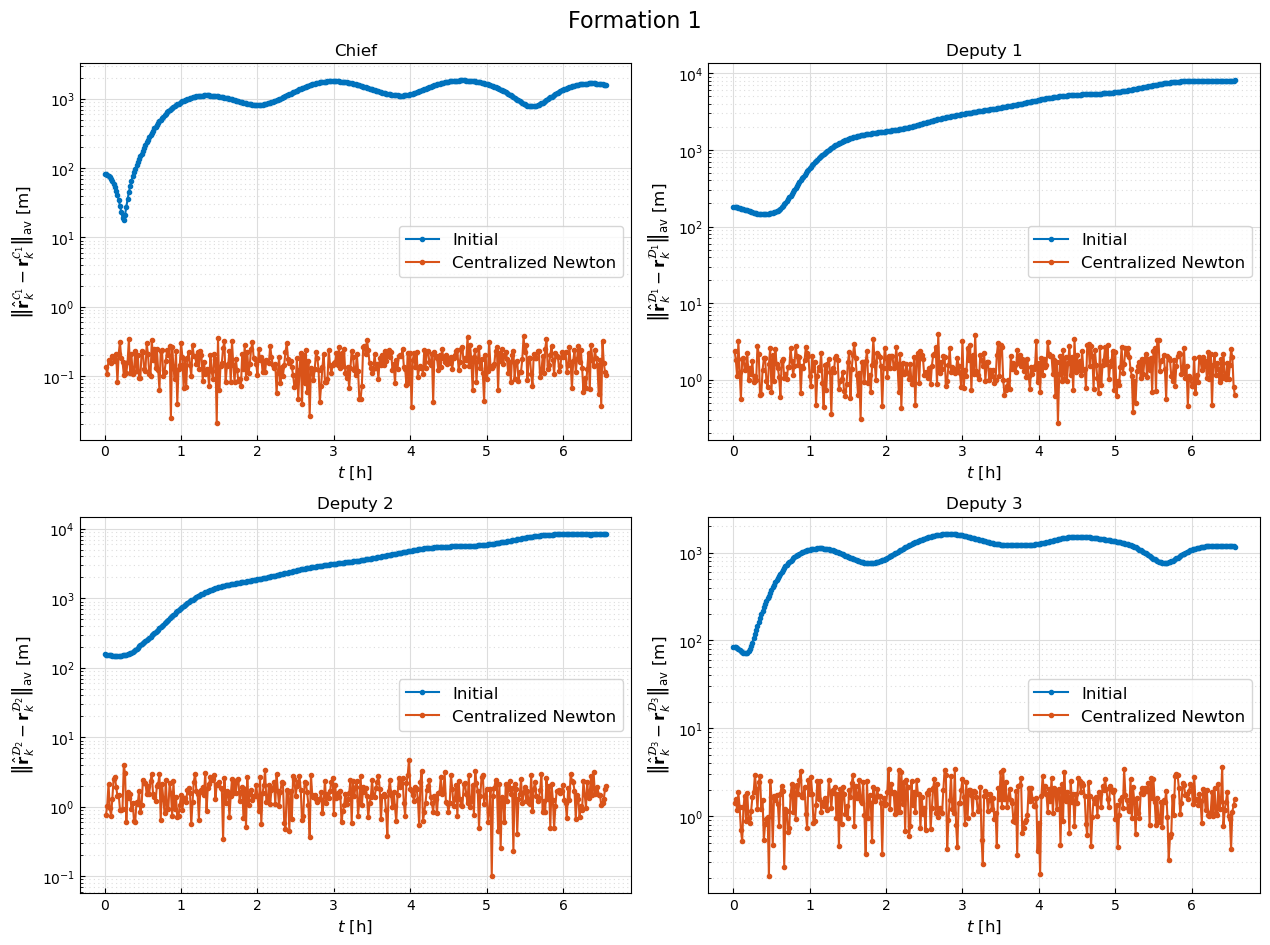

In [ ]:
# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, K) / dt
algorithm = "Centralized Newton"

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, position_estimation_error_1_initial, ".-", label="Initial")
axs[0, 0].plot(time[H - 1:], position_estimation_error_1, ".-", label=algorithm)
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, position_estimation_error_2_initial, ".-", label="Initial")
axs[0, 1].plot(time[H - 1:], position_estimation_error_2, ".-", label=algorithm)
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, position_estimation_error_3_initial, ".-", label="Initial")
axs[1, 0].plot(time[H - 1:], position_estimation_error_3, ".-", label=algorithm)
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, position_estimation_error_4_initial, ".-", label="Initial")
axs[1, 1].plot(time[H - 1:], position_estimation_error_4, ".-", label=algorithm)
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()